In [30]:
library(readr)
library(qqman)
library(dplyr)
library(ggplot2)
library(ggrepel)
library(data.table)

# Load Genes

In [31]:
# 0. Read your annotation & prune files
genes <- read_tsv(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/Annotations_File/ukb_genoHM3.annot.genesymbol_mapped.pvar.gz"
) %>%
  mutate(
    ID          = toupper(as.character(ID)),
    in_LDSC_hm3 = as.logical(in_LDSC_hm3)
  )

prune_df <- fread(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/GWAS/Reference_Files/LD_Inclusion/ukb_genoHM3.WB.8r2.prune.in",
  header    = FALSE,
  col.names = "SNP"
)

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 1316181 Columns: 26
── Column specification ─────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (18): #CHROM, ID, REF, ALT, FILTER, geno_source, ID_UKB, Existing_variat...
dbl  (6): POS, UKB_all_missing, UKB_all_OBSCT, UKB_WB_AF, gnomAD_NFE_AF, HWE_p
lgl  (2): in_LDSC_hm3, liftOver_unmapped_reason

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Helper Functions

In [32]:
# 1. Define prep_gwas (no P-value filter here)
prep_gwas <- function(path) {
  read_tsv(path, col_types = cols()) %>%
    rename(
      SNP = ID,
      CHR = `#CHROM`,
      BP  = POS
    ) %>%
    mutate(
      P   = 10^(-LOG10_P),
      SNP = toupper(SNP),
      CHR = case_when(
        CHR == "X" ~ 23L,
        CHR == "Y" ~ 24L,
        TRUE       ~ as.integer(CHR)
      )
    ) %>%
    inner_join(genes, by = c("SNP" = "ID"))
}

# Trait Comparison Plots

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“Th

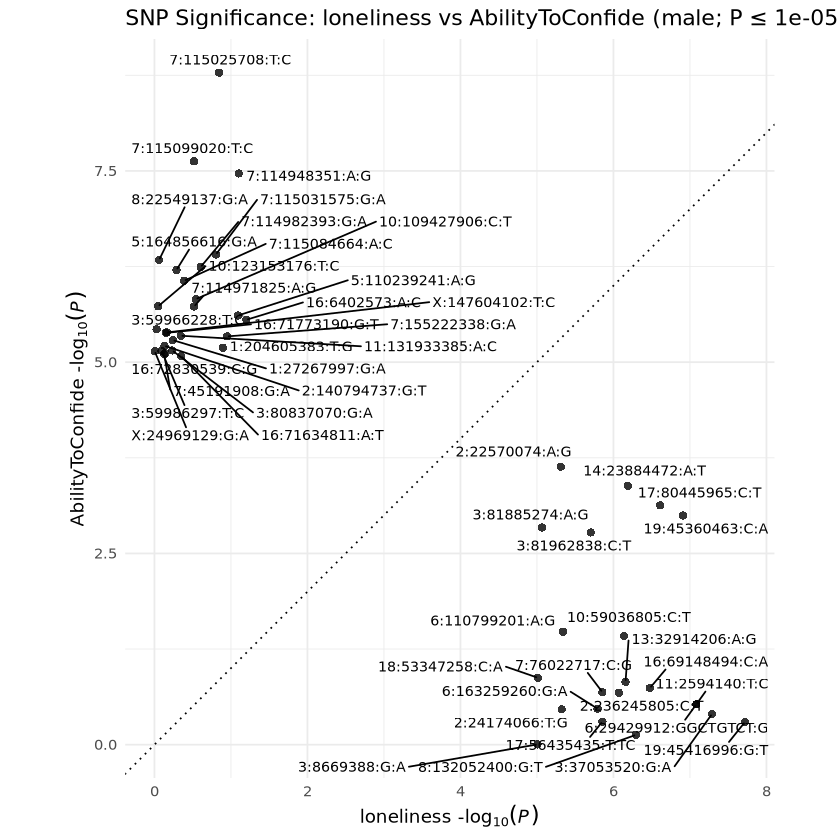

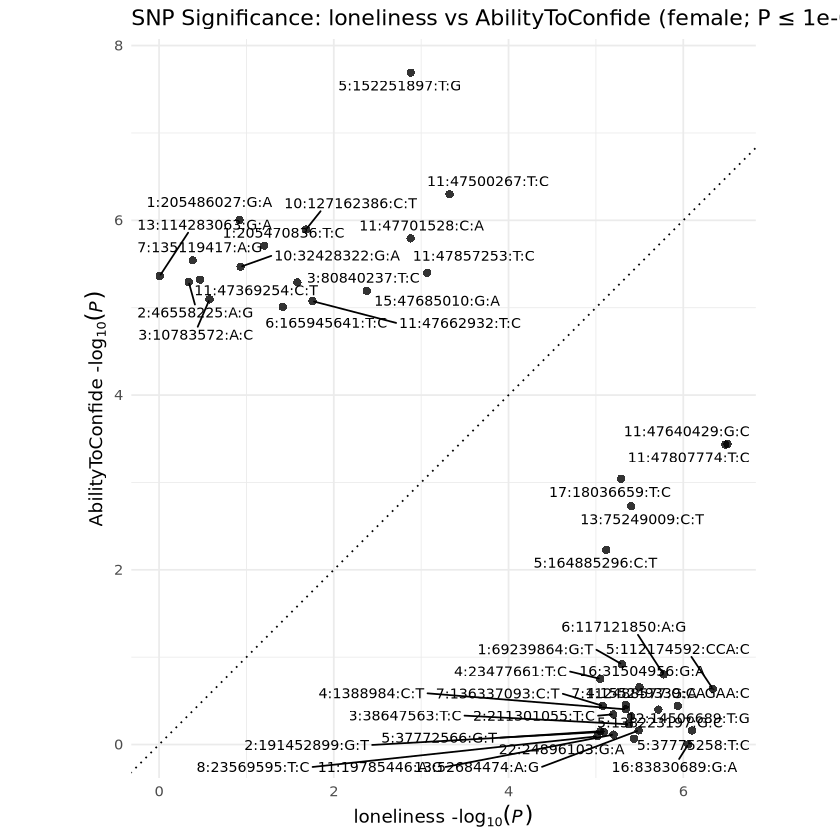

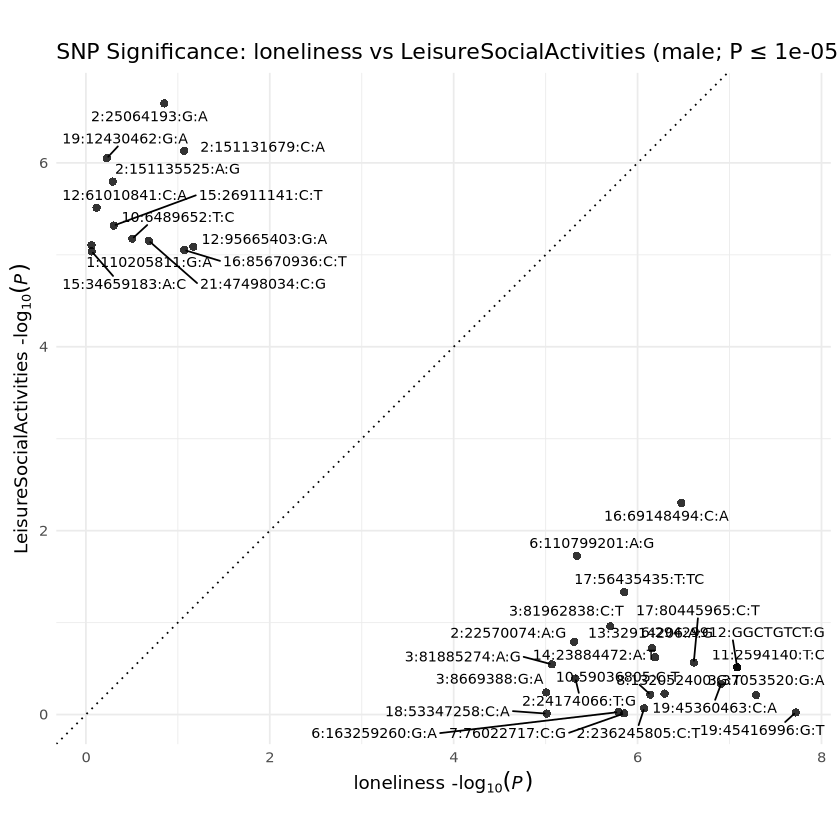

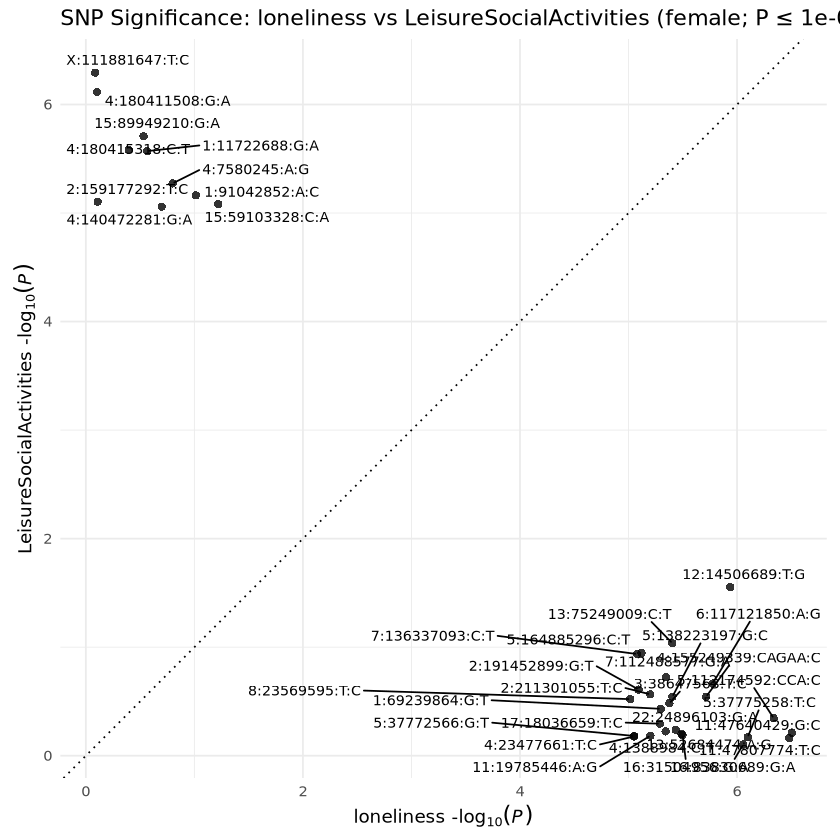

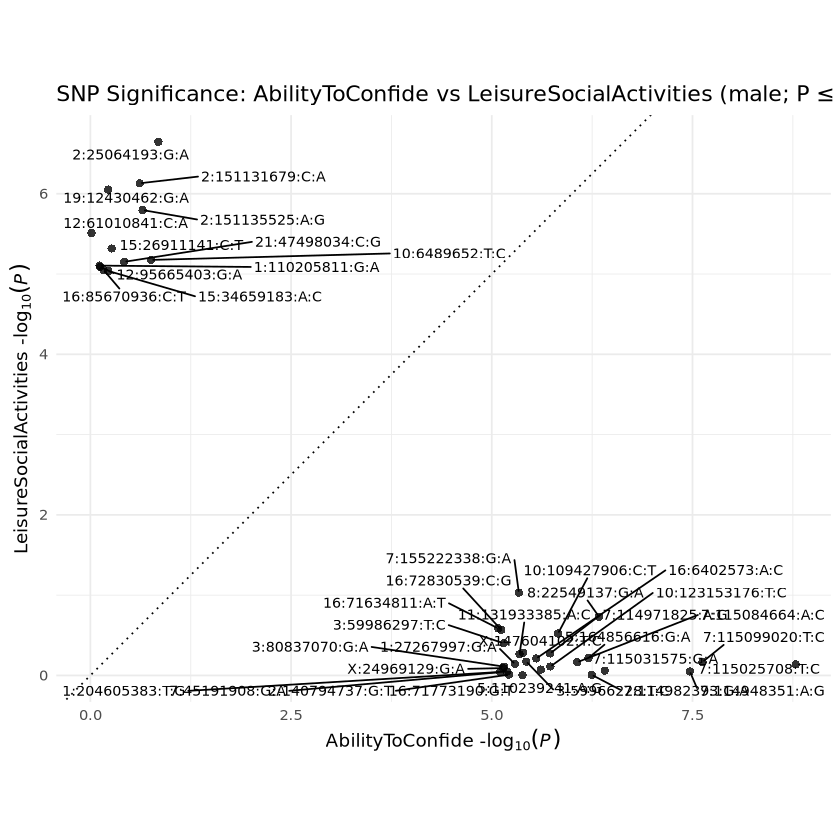

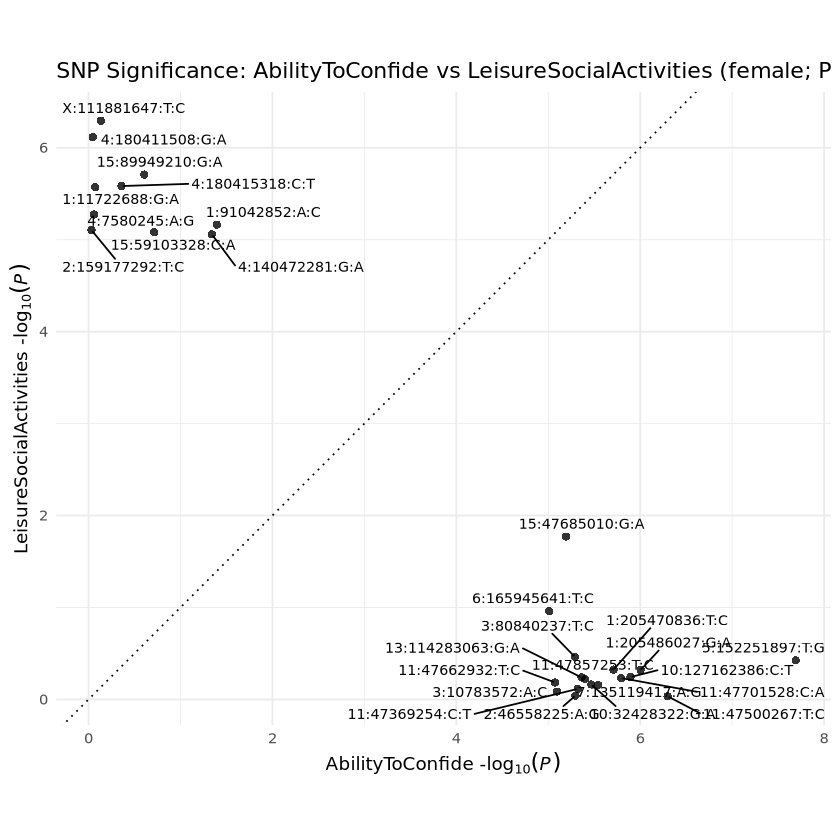

In [33]:
# =============================================
#  Full script: Pairwise –log₁₀(P) comparisons
#  (with ggrepel labeling, exact file paths)
# =============================================

# 0. Load libraries
library(readr)
library(dplyr)
library(ggplot2)
library(data.table)
library(ggrepel)

# 1. Define prep_gwas()
prep_gwas <- function(path) {
  read_tsv(path, col_types = cols()) %>%
    rename(
      SNP = ID,
      CHR = `#CHROM`,
      BP  = POS
    ) %>%
    mutate(
      P   = 10^(-LOG10_P),
      SNP = toupper(SNP),
      CHR = case_when(
        CHR == "X" ~ 23L,
        CHR == "Y" ~ 24L,
        TRUE       ~ as.integer(CHR)
      )
    ) %>%
    inner_join(genes, by = c("SNP" = "ID")) %>%
    semi_join(prune_df, by = "SNP")
}

# 2. Exact file paths for each trait
trait_files <- list(
  loneliness = list(
    male   = "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/loneliness/WB_Male/Loneliness.glm.tsv.gz",
    female = "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/loneliness/WB_Female/Loneliness.glm.tsv.gz"
  ),
  AbilityToConfide = list(
    male   = "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/AbilityToConfide/WB_Male/AbilityToConfide.glm.tsv.gz",
    female = "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/AbilityToConfide/WB_Female/AbilityToConfide.glm.tsv.gz"
  ),
  LeisureSocialActivities = list(
    male   = "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/LeisureSocialActivities/WB_Male/LeisureSocialActivities.glm.tsv.gz",
    female = "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/LeisureSocialActivities/WB_Female/LeisureSocialActivities.glm.tsv.gz"
  )
)

# 3. Load & prep all GWAS tables
gwas_data <- lapply(names(trait_files), function(trait) {
  paths <- trait_files[[trait]]
  list(
    male   = prep_gwas(paths$male)   %>% rename(!!paste0("P_", trait) := P),
    female = prep_gwas(paths$female) %>% rename(!!paste0("P_", trait) := P)
  )
})
names(gwas_data) <- names(trait_files)

# 4. Significance threshold
p_thresh <- 1e-5

# 5. All pairwise trait comparisons
trait_pairs <- combn(names(gwas_data), 2, simplify = FALSE)

for(pair in trait_pairs) {
  t1 <- pair[1]
  t2 <- pair[2]
  
  for(sex in c("male", "female")) {
    # join the two P‐value columns by SNP
    df1 <- gwas_data[[t1]][[sex]]   %>% select(SNP, starts_with(paste0("P_", t1)))
    df2 <- gwas_data[[t2]][[sex]]   %>% select(SNP, starts_with(paste0("P_", t2)))
    
    dt <- inner_join(df1, df2, by = "SNP") %>%
      rename(
        P1 = !!paste0("P_", t1),
        P2 = !!paste0("P_", t2)
      ) %>%
      filter( (P1 <= p_thresh) | (P2 <= p_thresh) ) %>%
      mutate(
        logP1      = -log10(P1),
        logP2      = -log10(P2),
        label_this = (P1 <= p_thresh) | (P2 <= p_thresh)
      )
    
    # build the plot
    p <- ggplot(dt, aes(x = logP1, y = logP2)) +
      geom_point(shape = 16, size = 2, alpha = 0.8) +
      geom_abline(intercept = 0, slope = 1, linetype = "dotted") +
      
      # label only the threshold‐passing SNPs
      geom_text_repel(
        data         = filter(dt, label_this),
        aes(label    = SNP),
        size         = 3,
        max.overlaps = Inf
      ) +
      
      coord_equal() +
      labs(
        x     = bquote(.(t1) ~ "-log"[10](italic(P))),
        y     = bquote(.(t2) ~ "-log"[10](italic(P))),
        title = paste0(
          "SNP Significance: ", t1, " vs ", t2,
          " (", sex, "; P ≤ ", format(p_thresh, scientific = TRUE), ")"
        )
      ) +
      theme_minimal()
    
    print(p)
  }
}


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”


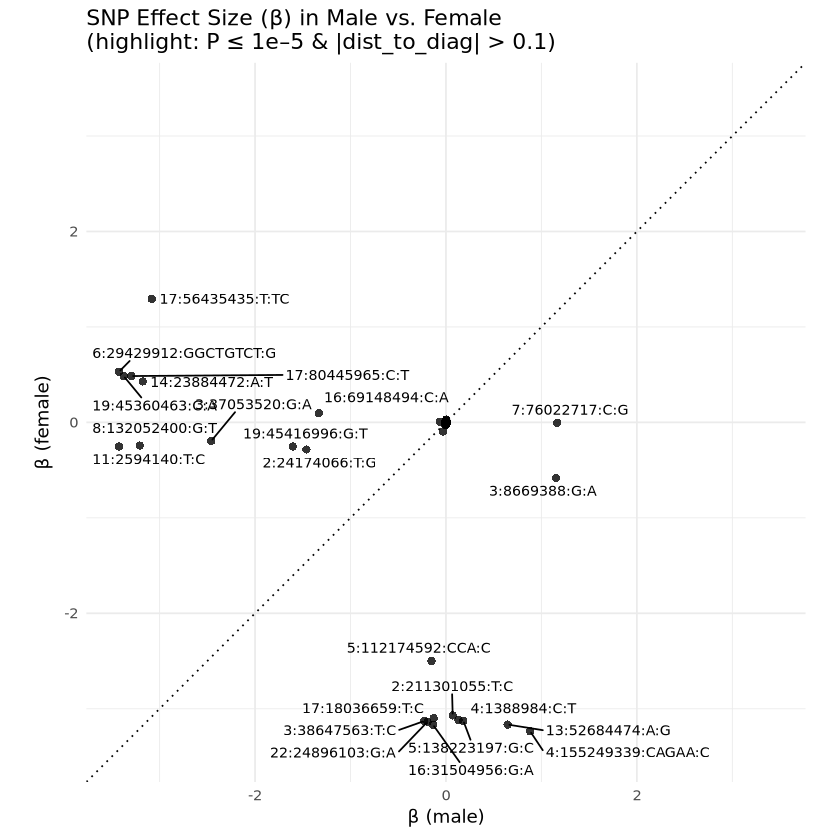

In [22]:
male_all <- prep_gwas(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/loneliness/WB_Male/Loneliness.glm.tsv.gz"
) %>%
  rename(
    P_male    = P,
    BETA_male = BETA
  ) %>%
  semi_join(prune_df, by = "SNP")

female_all <- prep_gwas(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/loneliness/WB_Female/Loneliness.glm.tsv.gz"
) %>%
  rename(
    P_female    = P,
    BETA_female = BETA
  ) %>%
  semi_join(prune_df, by = "SNP")

# 3. Merge & filter on P ≤ 1e-5 in at least one sex
dt <- full_join(male_all, female_all, by = "SNP") %>%
  filter(
    ( !is.na(P_male)   & P_male   <= 1e-5 ) |
    ( !is.na(P_female) & P_female <= 1e-5 )
  )

# 4. Flag all SNPs passing the P‐value threshold
p_thresh <- 1e-5
dt <- dt %>%
  mutate(
    label_this = (P_male   <= p_thresh) |
                 (P_female <= p_thresh)
  )

# 5. Compute distance to the diagonal y = x and decide which to label
dt2 <- dt %>%
  mutate(
    dist_to_diag = abs(BETA_female - BETA_male) / sqrt(2),
    label_plot   = label_this & (dist_to_diag > 0.1)
  )

# 6. Determine symmetric axis limits so that (0,0) is centered
max_beta <- max(abs(c(dt2$BETA_male, dt2$BETA_female)), na.rm = TRUE)

# 7. Final annotated β vs. β plot
ggplot(dt2, aes(x = BETA_male, y = BETA_female)) +
  geom_point(shape = 16, size = 2, alpha = 0.8) +
  geom_abline(intercept = 0, slope = 1, linetype = "dotted") +

  # label only the SNPs that are significant & >0.1 from the diagonal
  geom_text_repel(
    data         = filter(dt2, label_plot),
    aes(label    = SNP),
    size         = 3,
    max.overlaps = Inf
  ) +

  # center at (0,0) with equal scales
  scale_x_continuous(limits = c(-max_beta, max_beta)) +
  scale_y_continuous(limits = c(-max_beta, max_beta)) +
  coord_equal() +

  labs(
    x     = expression(italic(beta)~"(male)"),
    y     = expression(italic(beta)~"(female)"),
    title = "SNP Effect Size (β) in Male vs. Female\n(highlight: P ≤ 1e–5 & |dist_to_diag| > 0.1)"
  ) +
  theme_minimal()
